# Activity 2.1. Linear Regression
## Introduction
In this activity you learn how to use an optimization algorithm, called Stochastic Gradient Descent (SGD), to build a linear model for regression. In Activity 2, you will be asked to expand the linear regression implementation and develop ridge regression algorithm (linear regression with $\ell_2$ regularization).

## Instructions
<ol>
	<li>Generate a synthetic dataset suitable for regression and divide it to train and test sets,
    <li>Choose and implement a basis function $\pmb{\phi}$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and termination threshold $\epsilon$.</li>
	<li> Use the above function and repeat the following until the difference between the old and new weight vectors becomes small (i.e., $d(\pmb{w}^{\tau+1}, \pmb{w}^{\tau}) \leq\epsilon$):
<ol>
	<li>Shuffle the training data</li>
	<li>For each datapoint in the training data do:
<ol>
	<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} + \eta (t - {\pmb{w}^{(\tau)}}.\pmb{\phi}_n) \pmb{\phi}_n$</li>
</ol>
</li>
</ol>
</li>
	<li>Plot the weights $\pmb{w}^{\tau}$ vs. iteration number $\tau$</li>
    <li>Plot the training and testing errors vs. iteration number $\tau$.</li>
    <li>Repeat the above experiments using different datasets, random seeds, initial weights, and $\epsilon$ value</li>
</ol>

## Implementation
### Dataset
Let start with loading libraries and generateing a synthetic dataset, as follows. Here, we generate $N$ data points generated uniformly at random (using `runif`). We then choose a weight vector (called `coeff`) using which we produce the corresponding target value for each data point.  In the training time, we pretend that we don't know the weight vector and we try to learn it using the generated training dataset.

In [10]:
library(ggplot2) # for plotting functions.
library(reshape2) # for melt and cast functions
set.seed(1234) # to make the results of stochastic methods reproducible

# geberate N x D data samples
N <- 200 # number of all data point (test and train)
D <- 4 # number of features/attributes i.e. x values

# creates a matrix of values between 0 and 1 that has N rows and D columns. Effectively generates a total of N
# random data points for D variables

data <- data.frame(matrix(runif(D*N), nrow=N, ncol=D))   

head(data) ## This example makes more sense when you see the output in this form before it is manipulated

X1,X2,X3,X4
0.1137034,0.6607546,0.6862423,0.2809718
0.6222994,0.5283594,0.4166287,0.1741882
0.6092747,0.3174938,0.7570262,0.1702244
0.6233794,0.7678555,0.7757949,0.5605436
0.8609154,0.5263085,0.5735870,0.4288006
0.6403106,0.7323019,0.1886988,0.3891868


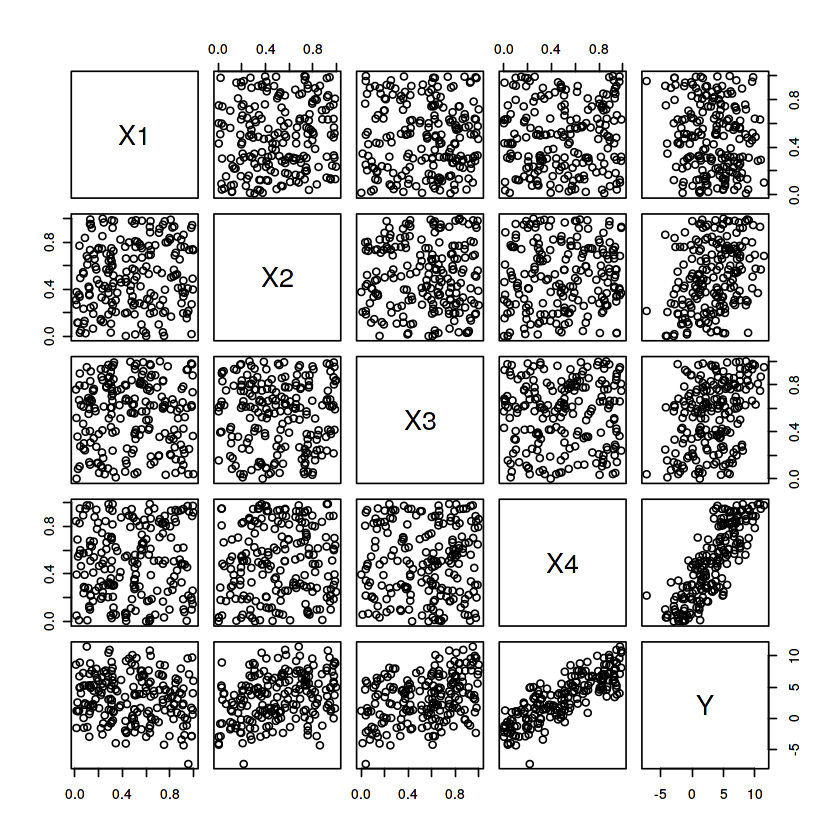

In [29]:
# generate the labels
# We're trying to generate a data set that is based off a linear equation with D dimensions (4 in this example).
# That means we have an equation of y = w0 + w1x1 + w2x2 + w3x3 + w4x4. In the last piece of code we created the X values.
# We're now going to create the W values.

# This creates a matrix of coefficients (W) for each of the terms in a linear equation. 
# There are D+1 rows because a linear equation also has a W0 coefficient 

coeff <- matrix(c(-5,-3,4,5,10), nrow=D+1, ncol=1) 

# Next the Y values are created and added to the data. To do this we effectively need to perfrom the multiplication operations on 
# the equation y = w0 + w1x1 + w2x2 + w3x3 + w4x4. The easiest way to do this for all N data points is to use a matrix.
# We need to first include W0 in our x-dataset because we haven't included it up to this point. Given W0 is the same as 1xW0
# the code simply adds 1 to all values in the first column of our data. That 5 column dataset now represents 1,x1,x2...x4.
# If we matrix multiple using %*% we end up solving the equation for y.
data <- cbind(data,'Y'=as.matrix(cbind(1,data[,1:D])) %*% coeff)

# add gaussian noise the labels (just to make it a little bit more challenging)
data$Y <- data$Y + rnorm(N, mean = 0, sd =1)  # This is a randomised sample from a normal distribution of sd 1
pairs(data)

Now, divide the dataset into testing and training sets

In [30]:
# divide data into training and testing sets
train.len <- N/2
train.index <- sample(1:N,train.len)
train.data <- data[train.index,  1:D]
train.label <- data[train.index, 'Y']
test.data <- data[-train.index, 1:D]
test.label <- data[-train.index, 'Y']

## Implementation
Now, based on the instruction, we initialize the parameter values.

### Auxilary Functions
To produce a clean and readable code, let us first define some auxiliary function that calculate the prediction and cost based on the projected data and estimated coefficients.

In [31]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w)  # This is the basis function for y(x,w) which is simply w * Phi(x) so we use matrix multiplication %*%
} 

# auxiliary function to calculate a cost function
# The cost function for linear regression is simply E(w) which is 1/2 of the sum of squared error.
# In our case the actual value is "label" and the predicted value is Phi(x) * w, that we created a value for in the
# predict_func function above. Therefore we simply plug them in

error_func <- function (Phi, w, label){
    return(sum((predict_func(Phi, w) - label)^2)/2) 
    # it may be easier to visualise the equation like this 0.5 * sum((predict_func(Phi, w) - label)^2)
}

### Initialization

In [60]:
# project data using a basis function (identical here)
Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as phi_0 because we define phi_0(x):=1 as a dummy basis function

T <- train.label # rename just for conviniance
tau.max <- 10000 # maximum number of iterations
eta <- 0.01 # learning rate

# Epsilon is the threshold to stop iterating because small step changes in ETA generally means the gradient will
# never exactly reach 0 so we can stop when "close enough" - https://mashimo.wordpress.com/2014/03/09/gradient-descent/
# Here 10% of the mean training y values is being used.
epsilon <- 0.1 * mean(T) # a threshold on the cost (to terminate the process)

# We need to create a space to store our estimated coefficients from the algorithm. Here a matrix is created with
# blank values (to be written in the main loop) that has number of iterations tau.max rows for each iteration
# and a value for each of the coefficients Phi.

W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients

# Set the very first row to a random set of values between 0-1 for each variable. This creates the initial weight
# that the algorithm will iterate from. Uniform random seems fine, so long as the values are already normalised.
W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?)

error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1 # iteration counter
terminate <- FALSE

### Main Loop

In [61]:
while(!terminate){
    # check termination criteria:
    # The terminate value is TRUE or FALSE. Therefore this sets the value to a logical operations.
    # This loop can terminate if the iteration "tau" exceeds the maximum set tau.max OR
    # If the actual derivatie (smallest sum of squares) is less than the threshold set (i.e. epsilon)
    # For the first run tau = 1 and W[tau,] is the weights we assigned randomly above
    # Each set of values for W is evaluated against the full set of x values hence error_func(Phi, W[tau,],T) with
    # no slicing of Phi
    terminate <- tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon
    
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)  # sample without replacement 1:training size
    Phi <- Phi[train.index,]  # Select from the training data loaded into Phi based on the random sample
    T <- T[train.index]  # Grab the predicted Y values for those samples
    
    # We loop through each datapoint and perfrom the error calculation based on our predictions.
    # At the start of each iteration, the termination criteria is checked and the loop is broken if
    # it is met.
    
    # for each datapoint:
    for (i in 1:train.len){
        
        # check termination criteria:
        if (tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon) {terminate<-TRUE;break}
        
        t_pred = predict_func(Phi[i,], W[tau,])  # Run the prediction function 
        
        # We need to know which way to update our weights for w values. We do this by funding the negative
        # direction of the gradient and shifting the value of W by that amount for the next iteration.
        # To do that we need to find that value for each X variable (i.e. partial derivative with respect to each)
        
        # for each coefficient:
        for (j in 1: ncol(W)){
            # update the coefficient:
            
            # Here we will use the partial derivative equation for the negative gradient:
            # nabla = upside down delta symbol
            # nabla E(w) = -[tn - w * phi(xn)]*phi(xn)
            # Notice that w * phi(xn) is exactly the equation we used in the "predict_func"
            
            # Therefore this equation is -[actual y - predicted y] * xn value at that n
            # This is repeated for each value of x, although in R this could be done using an apply function
                      
           
            W[(tau+1),j] <- W[tau,j] + eta * (T[i]-t_pred) * Phi[i,j]  # 
            
            # W[tau,j] <- W^(t-1) means that the next iteration weight should be equal to the last iteration + our change
            # eta is our learning step. We want to update our weights by a factor of the learning rate
            # (T[i]-t_pred) * Phi[i,j] = (Y value - Predicted Y value) * training x value
            # Phi[i,j] = the value of the x variable in the training set at iteration i and variable J
            
        }

        # Once we have calculated the step change we need to make for each x variable and updated our weights
        # We can calculate the overall sum-of-squares error function based on those values. We do this by passing
        # to the "error_func" function we created earlier.
        # This function is taking our 4 predictions for the coefficients (w) and predicting the y value
        # for eavery example in the training set. It then does this again on the test set
        
        # record the error:
        
        
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error[tau, 'test'] <- error_func(as.matrix(cbind(1, test.data)), W[tau,],test.label)
        
        # update the counter:
        tau <- tau + 1        
    }
}
error.m <- melt(error[1:tau,], id='tau')

# the  final result is:
w <- W[tau,]
cat('The  real coefficents are:',coeff,'\nThe  final coefficents are:',w)

The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -4.983791 -2.192355 3.632122 4.467108 10.1921

In [62]:

### AS above but with 1 fewer loops ###

while(!terminate){
    # check termination criteria:
    # The terminate value is TRUE or FALSE. Therefore this sets the value to a logical operations.
    # This loop can terminate if the iteration "tau" exceeds the maximum set tau.max OR
    # If the actual derivatie (smallest sum of squares) is less than the threshold set (i.e. epsilon)
    # For the first run tau = 1 and W[tau,] is the weights we assigned randomly above
    # Each set of values for W is evaluated against the full set of x values hence error_func(Phi, W[tau,],T) with
    # no slicing of Phi
    terminate <- tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon

    train.index <- sample(1:train.len, train.len, replace = FALSE)  # sample without replacement 1:training size
    Phi <- Phi[train.index,]  # Select from the training data loaded into Phi based on the random sample
    T <- T[train.index]  # Grab the predicted Y values for those samples
    
    # We loop through each datapoint and perfrom the error calculation based on our predictions.
    # At the start of each iteration, the termination criteria is checked and the loop is broken if
    # it is met.
    
    # for each datapoint:
    for (i in 1:train.len){
        
        # check termination criteria:
        if (tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon) {terminate<-TRUE;break}
        
        t_pred = predict_func(Phi[i,], W[tau,])  # Run the prediction function 
        
        # We need to know which way to update our weights for w values. We do this by funding the negative
        # direction of the gradient and shifting the value of W by that amount for the next iteration.
        # To do that we need to find that value for each X variable (i.e. partial derivative with respect to each)
        

        # Here we will use the partial derivative equation for the negative gradient:
        # nabla = upside down delta symbol
        # nabla E(w) = -[tn - w * phi(xn)]*phi(xn)
        # Notice that w * phi(xn) is exactly the equation we used in the "predict_func"

        # Therefore this equation is -[actual y - predicted y] * xn value at that n
        # This is repeated for each value of x, although in R this could be done using an apply function as per below
                   
        W[(tau+1),] <- W[tau,] + rep(eta,D+1) * rep((T[i]-t_pred),D+1) * Phi[i,]  # repeat single value vectors D+1 times

        # W[tau,j] <- W^(t-1) means that the next iteration weight should be equal to the last iteration + our change
        # eta is our learning step. We want to update our weights by a factor of the learning rate
        # (T[i]-t_pred) * Phi[i,j] = (Y value - Predicted Y value) * training x value
        # Phi[i,j] = the value of the x variable in the training set at iteration i and variable J

        # Once we have calculated the step change we need to make for each x variable and updated our weights
        # We can calculate the overall sum-of-squares error function based on those values. We do this by passing
        # to the "error_func" function we created earlier.
        # This function is taking our 4 predictions for the coefficients (w) and predicting the y value
        # for eavery example in the training set. It then does this again on the test set
        
        # record the error:
        
        
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error[tau, 'test'] <- error_func(as.matrix(cbind(1, test.data)), W[tau,],test.label)
        
        # update the counter:
        
        tau <- tau + 1        
    }
}
error.m <- melt(error[1:tau,], id='tau')

# the  final result is:
w <- W[tau,]
cat('The  real coefficents are:',coeff,'\nThe  final coefficents are:',w)

The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -4.983791 -2.192355 3.632122 4.467108 10.1921

### Visualizations

  Let's plot the errors of the learned weight vectors over the training iterations on the training and test sets.

Warning message:
: Removed 2 rows containing missing values (geom_path).

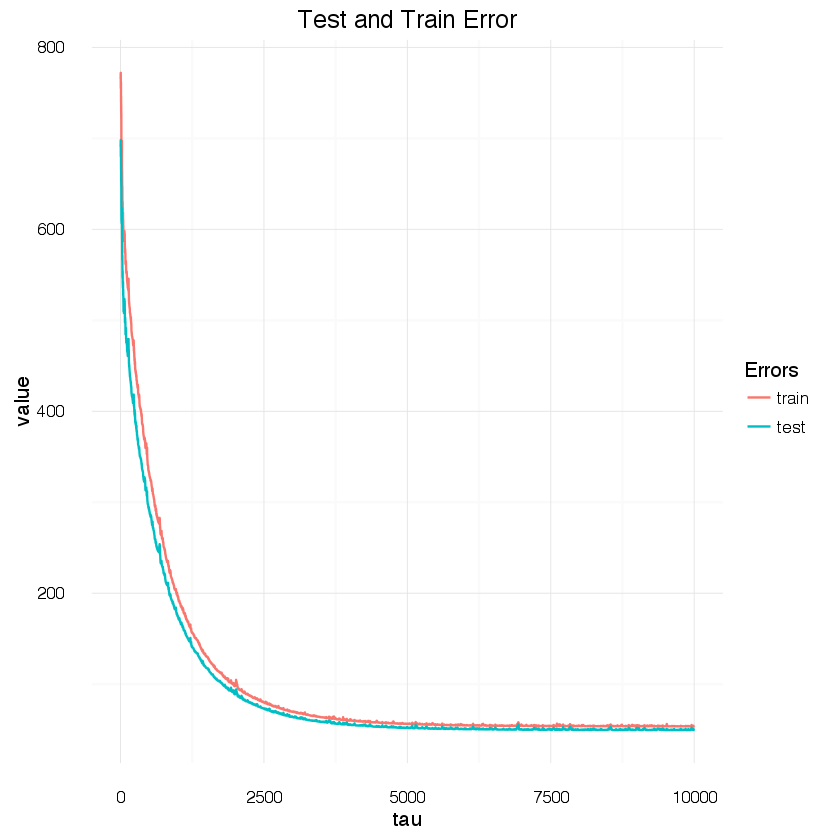

In [10]:
ggplot(data=error.m, aes(x=tau, y=value, color=variable)) +
    geom_line() + ggtitle('Test and Train Error') +
    scale_color_discrete(guide = guide_legend(title = 'Errors')) +theme_minimal()
  

Now let's plot the elements of the learned weight vectors over the training iterations.

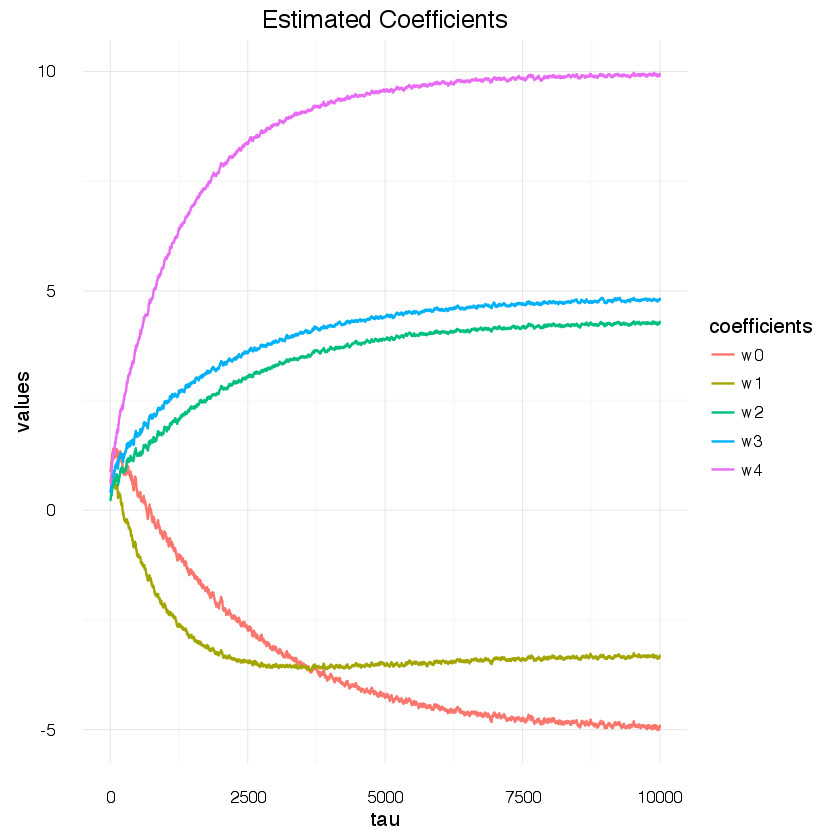

In [11]:
W.m <- as.data.frame(W); names(W.m)<-c('w0','w1','w2','w3','w4')
W.m$tau<-1:nrow(W)
W.m <-melt(W.m, id='tau'); names(W.m) <- c('tau', 'coefficients', 'values')
ggplot(data=W.m, aes(x=tau, y=values, color=coefficients)) + geom_line() + ggtitle('Estimated Coefficients') + theme_minimal()

## Discussions
<ol>

	<li>How the learning rate can affect the convergence rate (i.e., when the algorithm stops improving) and prediction error? Choose some other constant values for the learning rate and investigate their effects.</li>
	<li>Do you believe having different learning rates at different iterations of the main learning loop can help? If it matters, is it better to have large values at start and smaller when close to finish or the other way around? Validate your intuition using monotonically increasing or decreasing learning rates as functions of $\tau$ (e.g. try $\frac{a}{b+\tau}$ for different values of $a$ and $b$).</li>
	<li>Modify your code and develop a batch gradient descent. The main difference is that you do not need to shuffle the training data, but have to include all training samples in the calculation of the weight updates in each iterations. Compare and discuss the convergence rates and final training error for SGD and batch GD. </li>
</ol>